In [31]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft



data = {}
for expt in ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20","full-40","beamless-40","smooth-40"]:
    path = Path(f"/scratch/nm03/ab8992/test/outputs") / expt
    bathy = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").sel(yb = slice(-120,120))
    data[expt] = xr.merge(
    [
        xr.open_dataset(path / "ke_modal.nc"),
        xr.open_dataset(path / "filtered_ke_bt.nc"),
        bathy.rename({"depth":"bathy"}) * -1
     ]
).sel(xb = slice(0,1200))


## First attempt with saturation denoting modes, colour denoting experiment


Text(0.5, 1.0, 'Semidiurnal energy decomposition')

<Figure size 1500x1000 with 0 Axes>

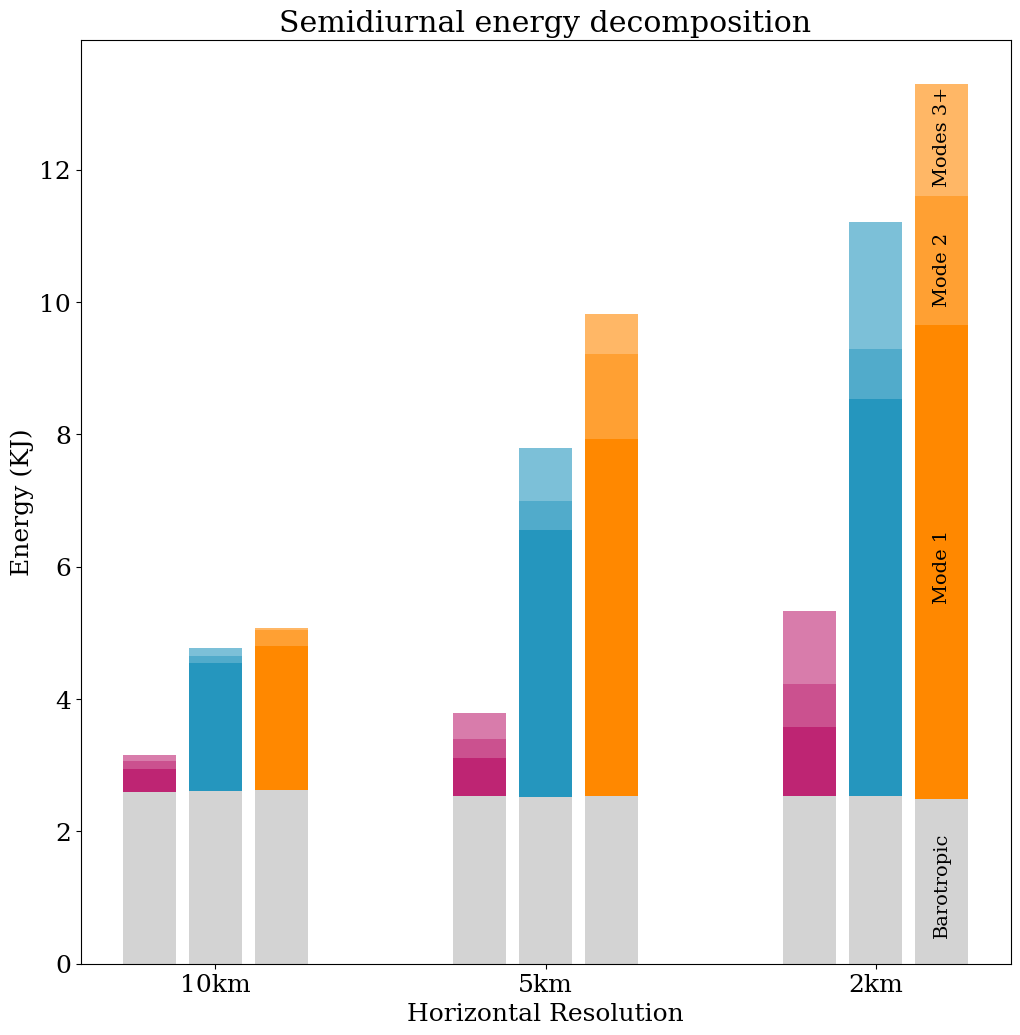

In [ ]:
import matplotlib.gridspec as gridspec
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(15, 10))


def ShelfMask(data):
    return data.sel(xb = slice(600,800))

# ShelfMask(data["full-40"]).filtered_dissipation.plot()
expts = ["beamless-10","full-10","smooth-10","beamless-20","full-20","smooth-20","beamless-40","full-40","smooth-40"]

# total_energy = 1000 * np.array([ShelfMask(data[expt]).raw_dissipation.mean("xb").mean("yb").values for expt in expts])
mode1 = np.array([ShelfMask(data[expt]).KE_modal.isel(mode = 0).mean("xb").mean("yb").values for expt in expts])
mode2 = np.array([ShelfMask(data[expt]).KE_modal.isel(mode = 1).mean("xb").mean("yb").values for expt in expts])
mode3 = np.array([ShelfMask(data[expt]).KE_modal.isel(mode = slice(2,None)).sum("mode").mean("xb").mean("yb").values for expt in expts])
barot = np.array([
    (
        ShelfMask(data[expt]).filtered_KE_bt.mean("xb").mean("yb").values
        ) for expt in expts
    ])



fig, ax = plt.subplots(figsize = (12,12))

group_gap = 2  # Gap between groups
bar_positions = np.array([
    0, 1, 2,  # First group
    3 + group_gap, 4 + group_gap, 5 + group_gap,  # Second group
    6 + 2 * group_gap, 7 + 2 * group_gap, 8 + 2 * group_gap  # Third group
])

colours_blank = ['lightgrey','#ecbed5', '#d87cab', '#be2573']  
colours_full = ['lightgrey','#bee0ec', '#7cc0d8', '#2596be']  
colours_smooth = ['lightgrey','#ffe7cc','#ffc480','#ff8800']

## Blank
blank1 = ax.bar(bar_positions[[0,3,6]], barot[[0,3,6]], label='Barotropic M2',color = colours_blank[0])
blank2 = ax.bar(bar_positions[[0,3,6]], mode1[[0,3,6]], bottom=barot[[0,3,6]], label='M2 Mode 1',color = colours_blank[1])
blank3 = ax.bar(bar_positions[[0,3,6]], mode2[[0,3,6]], bottom=barot[[0,3,6]] + mode1[[0,3,6]], label='M2 Mode 2',color = colours_blank[2])
blank4 = ax.bar(bar_positions[[0,3,6]], mode3[[0,3,6]], bottom=barot[[0,3,6]] + mode1[[0,3,6]] + mode2[[0,3,6]], label='M2 Mode 3+',color = colours_blank[3])

## Blank
full1 = ax.bar(bar_positions[[1,4,7]], barot[[1,4,7]], label='Barotropic M2',color = colours_full[0])
full2 = ax.bar(bar_positions[[1,4,7]], mode1[[1,4,7]], bottom=barot[[1,4,7]], label='M2 Mode 1',color = colours_full[1])
full3 = ax.bar(bar_positions[[1,4,7]], mode2[[1,4,7]], bottom=barot[[1,4,7]] + mode1[[1,4,7]], label='M2 Mode 2',color = colours_full[2])
full4 = ax.bar(bar_positions[[1,4,7]], mode3[[1,4,7]], bottom=barot[[1,4,7]] + mode1[[1,4,7]] + mode2[[1,4,7]], label='M2 Mode 3+',color = colours_full[3])

## Smooth
smooth1 = ax.bar(bar_positions[[2,5,8]], barot[[2,5,8]], label='Barotropic M2',color = colours_smooth[0])
smooth2 = ax.bar(bar_positions[[2,5,8]], mode1[[2,5,8]], bottom=barot[[2,5,8]], label='M2 Mode 1',color = colours_smooth[1])
smooth3 = ax.bar(bar_positions[[2,5,8]], mode2[[2,5,8]], bottom=barot[[2,5,8]] + mode1[[2,5,8]], label='M2 Mode 2',color = colours_smooth[2])
smooth4 = ax.bar(bar_positions[[2,5,8]], mode3[[2,5,8]], bottom=barot[[2,5,8]] + mode1[[2,5,8]] + mode2[[2,5,8]], label='M2 Mode 3+',color = colours_smooth[3])

# bars10 = ax.bar(expts,notm2, bottom=mode1 + mode2 + mode3 + mode4 + mode5 + mode6 + mode7 + mode8 + barot, label='Non M2')
# bars6 = ax.bar(expts, non_m2, bottom=mode1 + mode2 + mode3 + mode4 + remaining_modes, label='Non M2')
# ax.legend()
ax.set_xticks([1,6,11])
ax.set_xticklabels(["10km", "5km", "2km"])


custom_linecollection = (
    plt.Line2D([0,1], [0,0], color=colours_blank[1], lw=10),
    plt.Line2D([0.5,1], [0,0], color=colours_blank[2], lw=2),
)

# Custom legend
custom_legend = [
    plt.bar([0], [0], color=colours_blank[1], lw=4, label='No Ridge'),
    plt.bar([0], [0], color=colours_full[1], lw=4, label='Realistic'),
    plt.bar([0], [0], color=colours_smooth[2], lw=4, label='Smoothed'),
    # plt.bar([0], [0], color="lightgrey", lw=4, label='Barotropic'),
]



from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#! Dodgy axis inset
ax_inset = inset_axes(plt.gca(), width="40%", height="20%", loc="upper left")  # Adjust size and location

spacing = 4


ax_inset.plot([-1, 0], [0, 0], color=colours_smooth[0], lw=10)
ax_inset.plot([0, 1], [0, 0], color=colours_smooth[1], lw=10)
ax_inset.plot([1, 2], [0, 0], color=colours_smooth[2], lw=10)
ax_inset.plot([2, 3], [0, 0], color=colours_smooth[3], lw=10)
ax_inset.plot([3, 4], [0, 0], color="white", lw=10)
ax_inset.set_xlim(-2, 6)

ax_inset.plot([-1, 0], spacing *np.array([1, 1]), color=colours_full[0], lw=10)
ax_inset.plot([0, 1], spacing *np.array([1, 1]), color=colours_full[1], lw=10)
ax_inset.plot([1, 2], spacing *np.array([1, 1]), color=colours_full[2], lw=10)
ax_inset.plot([2, 3], spacing *np.array([1, 1]), color=colours_full[3], lw=10)
ax_inset.plot([3, 4], spacing *np.array([1, 1]), color="white", lw=10)
ax_inset.set_xlim(-2, 6)

ax_inset.plot([-1, 0], spacing * np.array([2, 2]), color=colours_blank[0], lw=10)
ax_inset.plot([0, 1], spacing * np.array([2, 2]), color=colours_blank[1], lw=10)
ax_inset.plot([1, 2], spacing * np.array([2, 2]), color=colours_blank[2], lw=10)
ax_inset.plot([2, 3], spacing * np.array([2, 2]), color=colours_blank[3], lw=10)
ax_inset.plot([3, 4], spacing * np.array([2, 2]), color="white", lw=10)
ax_inset.set_xlim(-1.5, 6)
ax_inset.set_ylim(-1 * spacing, spacing * 3)

ax_inset.set_title("")
ax_inset.set_xlabel("")
ax_inset.set_ylabel("")
ax_inset.set_yticks([])
ax_inset.set_xticks([])
ax_inset.spines['top'].set_color('lightgrey')    # Set top spine color
ax_inset.spines['bottom'].set_color('lightgrey')  # Set bottom spine color
ax_inset.spines['left'].set_color('lightgrey')    # Set left spine color
ax_inset.spines['right'].set_color('lightgrey')  # Set right spine color
ax_inset.tick_params(axis="both", which="major", labelsize=8)

## Add text to axis
ax_inset.text(3.5, -0.1, "Smoothed", ha="left", va="center", fontsize=16)
ax_inset.text(3.5, spacing - 0.1, "Realistic", ha="left", va="center", fontsize=16)
ax_inset.text(3.5, 2 * spacing - 0.1, "No Ridge", ha="left", va="center", fontsize=16)

## Add text to main
ax.text(12, 1.2, "Barotropic", ha="center", va="center", fontsize=14, rotation=90)
ax.text(12, 6, "Mode 1", ha="center", va="center", fontsize=14, rotation=90)
ax.text(12, 10.5, "Mode 2", ha="center", va="center", fontsize=14, rotation=90)
ax.text(12, 12.5, "Modes 3+", ha="center", va="center", fontsize=14, rotation=90)


#! Dodgy axis inset


# ax.legend(handles=custom_legend, loc='upper left')
# ax.legend(loc='upper left',handler_map={color_line: HandlerColorLineCollection(cmap="plasma", numpoints=30)})

ax.set_xlabel("Horizontal Resolution")
ax.set_ylabel("Energy (KJ)")
ax.set_title("Semidiurnal energy decomposition")

## Try Andrew's suggestion with hue being mode number and saturation being topo

<Figure size 1500x1000 with 0 Axes>

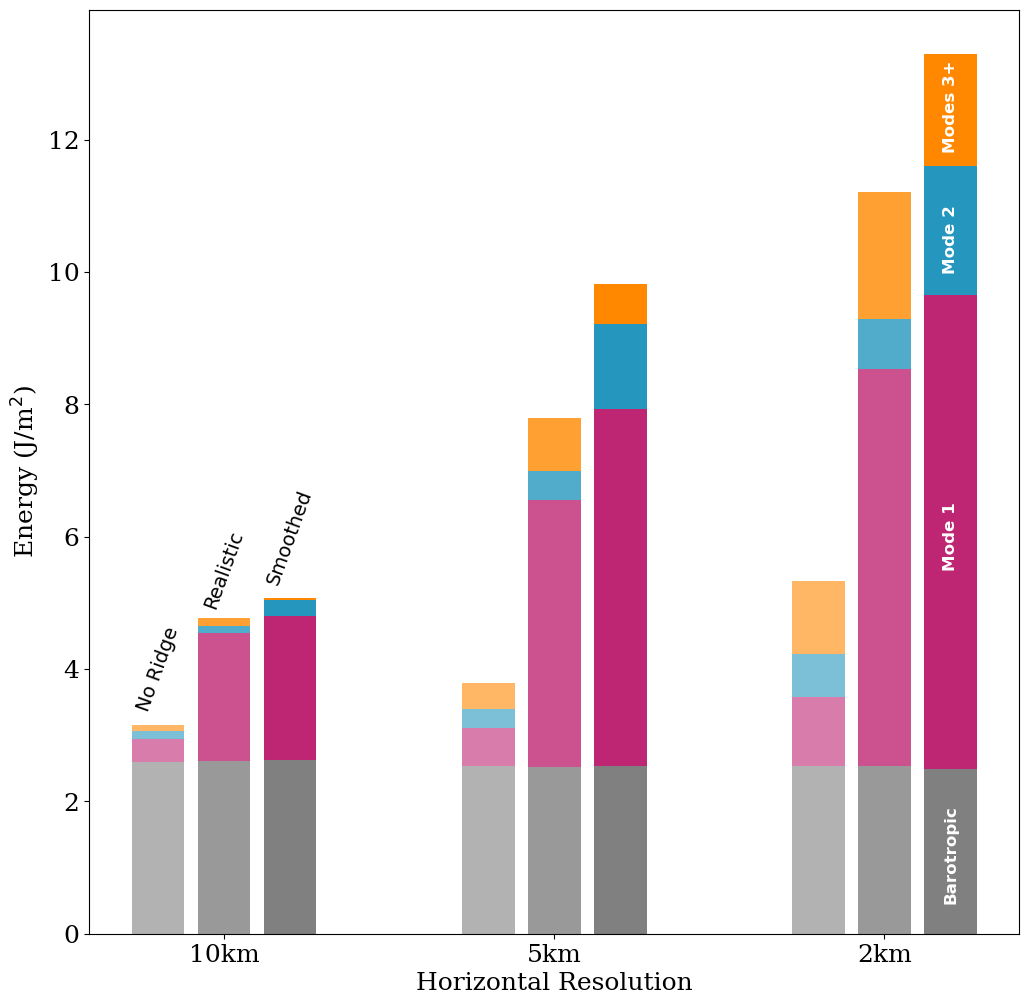

In [50]:
import matplotlib.gridspec as gridspec
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(15, 10))


def ShelfMask(data):
    return data.sel(xb = slice(600,800))

# ShelfMask(data["full-40"]).filtered_dissipation.plot()
expts = ["beamless-10","full-10","smooth-10","beamless-20","full-20","smooth-20","beamless-40","full-40","smooth-40"]

# total_energy = 1000 * np.array([ShelfMask(data[expt]).raw_dissipation.mean("xb").mean("yb").values for expt in expts])
mode1 = np.array([ShelfMask(data[expt]).KE_modal.isel(mode = 0).mean("xb").mean("yb").values for expt in expts])
mode2 = np.array([ShelfMask(data[expt]).KE_modal.isel(mode = 1).mean("xb").mean("yb").values for expt in expts])
mode3 = np.array([ShelfMask(data[expt]).KE_modal.isel(mode = slice(2,None)).sum("mode").mean("xb").mean("yb").values for expt in expts])
barot = np.array([
    (
        ShelfMask(data[expt]).filtered_KE_bt.mean("xb").mean("yb").values
        ) for expt in expts
    ])



fig, ax = plt.subplots(figsize = (12,12))

group_gap = 2  # Gap between groups
bar_positions = np.array([
    0, 1, 2,  # First group
    3 + group_gap, 4 + group_gap, 5 + group_gap,  # Second group
    6 + 2 * group_gap, 7 + 2 * group_gap, 8 + 2 * group_gap  # Third group
])

colours_blank = ['lightgrey','#ecbed5', '#d87cab', '#be2573']  
colours_full = ['lightgrey','#bee0ec', '#7cc0d8', '#2596be']  
colours_smooth = ['lightgrey','#ffe7cc','#ffc480','#ff8800']

colours_blank = ['lightgrey','#ecbed5', '#bee0ec', '#ffe7cc']  
colours_full = ['darkgrey','#d87cab', '#7cc0d8', '#ffc480']  
colours = ['grey','#be2573','#2596be','#ff8800']


alphablank = 0.6
alphafull = 0.8

## Blank
blank1 = ax.bar(bar_positions[[0,3,6]], barot[[0,3,6]], label='Barotropic M2',color = colours[0],alpha = alphablank)
blank2 = ax.bar(bar_positions[[0,3,6]], mode1[[0,3,6]], bottom=barot[[0,3,6]], label='M2 Mode 1',color = colours[1],alpha = alphablank)
blank3 = ax.bar(bar_positions[[0,3,6]], mode2[[0,3,6]], bottom=barot[[0,3,6]] + mode1[[0,3,6]], label='M2 Mode 2',color = colours[2],alpha = alphablank)
blank4 = ax.bar(bar_positions[[0,3,6]], mode3[[0,3,6]], bottom=barot[[0,3,6]] + mode1[[0,3,6]] + mode2[[0,3,6]], label='M2 Mode 3+',color = colours[3],alpha = alphablank)

## Blank
full1 = ax.bar(bar_positions[[1,4,7]], barot[[1,4,7]], label='Barotropic M2',color = colours[0],alpha = alphafull)
full2 = ax.bar(bar_positions[[1,4,7]], mode1[[1,4,7]], bottom=barot[[1,4,7]], label='M2 Mode 1',color = colours[1],alpha = alphafull)
full3 = ax.bar(bar_positions[[1,4,7]], mode2[[1,4,7]], bottom=barot[[1,4,7]] + mode1[[1,4,7]], label='M2 Mode 2',color = colours[2],alpha = alphafull)
full4 = ax.bar(bar_positions[[1,4,7]], mode3[[1,4,7]], bottom=barot[[1,4,7]] + mode1[[1,4,7]] + mode2[[1,4,7]], label='M2 Mode 3+',color = colours[3],alpha = alphafull)

## Smooth
smooth1 = ax.bar(bar_positions[[2,5,8]], barot[[2,5,8]], label='Barotropic M2',color = colours[0])
smooth2 = ax.bar(bar_positions[[2,5,8]], mode1[[2,5,8]], bottom=barot[[2,5,8]], label='M2 Mode 1',color = colours[1])
smooth3 = ax.bar(bar_positions[[2,5,8]], mode2[[2,5,8]], bottom=barot[[2,5,8]] + mode1[[2,5,8]], label='M2 Mode 2',color = colours[2])
smooth4 = ax.bar(bar_positions[[2,5,8]], mode3[[2,5,8]], bottom=barot[[2,5,8]] + mode1[[2,5,8]] + mode2[[2,5,8]], label='M2 Mode 3+',color = colours[3])

# bars10 = ax.bar(expts,notm2, bottom=mode1 + mode2 + mode3 + mode4 + mode5 + mode6 + mode7 + mode8 + barot, label='Non M2')
# bars6 = ax.bar(expts, non_m2, bottom=mode1 + mode2 + mode3 + mode4 + remaining_modes, label='Non M2')
# ax.legend()
ax.set_xticks([1,6,11])
ax.set_xticklabels(["10km", "5km", "2km"])


custom_linecollection = (
    plt.Line2D([0,1], [0,0], color=colours[1], lw=10),
    plt.Line2D([0.5,1], [0,0], color=colours[2], lw=2),
)

# Custom legend
custom_legend = [
    plt.bar([0], [0], color=colours_smooth[0], lw=4, label='Barotropic'),
    plt.bar([0], [0], color=colours_smooth[1], lw=4, label='Mode 1'),
    plt.bar([0], [0], color=colours_smooth[2], lw=4, label='Mode 2'),
    plt.bar([0], [0], color=colours_smooth[3], lw=4, label='Mode 3+'),
]



## Add text to main


## Add text to main
font = {'family': 'sans-serif',
    'weight': 'normal',
    'size': 18}

ax.text(12, 1.2, "Barotropic", ha="center", va="center", fontsize=12, rotation=90, color="white", fontweight="bold",font = font)
ax.text(12, 6, "Mode 1", ha="center", va="center", fontsize=12, rotation=90, color="white", fontweight="bold",font = font)
ax.text(12, 10.5, "Mode 2", ha="center", va="center", fontsize=12, rotation=90,color = "white",fontweight="bold",font = font)
ax.text(12, 12.5, "Modes 3+", ha="center", va="center", fontsize=12, rotation=90,color = "white",fontweight="bold",font = font)

ax.text(0, 4, "No Ridge", ha="center", va="center", fontsize=14, rotation=70,color = "black",font = font)
ax.text(1, 5.5, "Realistic", ha="center", va="center", fontsize=14, rotation=70,color = "black",font = font)
ax.text(2, 6, "Smoothed", ha="center", va="center", fontsize=14, rotation=70,color = "black",font = font)



# ax.legend(handles=custom_legend, loc='upper left')
# ax.legend(loc='upper left',handler_map={color_line: HandlerColorLineCollection(cmap="plasma", numpoints=30)})

ax.set_xlabel("Horizontal Resolution")
ax.set_ylabel("Energy (J/m$^2$)")
ax.set_title("")


# fig.savefig("/home/ashley/Documents/PhD/Paper-Tasman-Tides/figures/KE_decomposition")
fig.savefig("asdf")